# Experiment of Latent graph signal recovery
by tianpei, Jan 30 2017

##  Network build and Node sample generation

In [1]:
import numpy as np
import scipy as sp
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib.pyplot as plt
import networkx as nx
from time import strftime, gmtime
#import graph_tool.all as gt
%matplotlib inline  

In [2]:
from latent_signal_network import latent_signal_network as lsn 

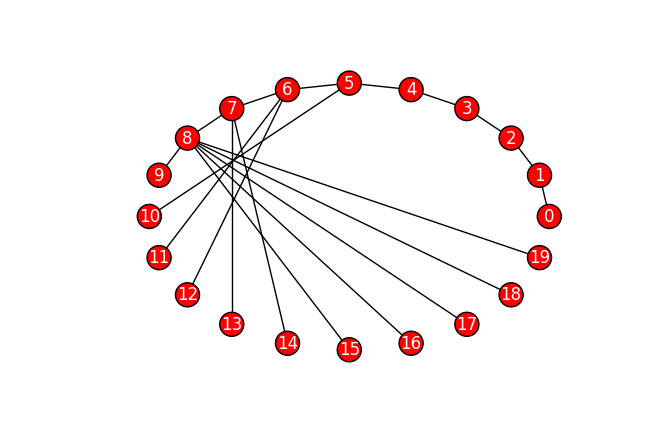

In [3]:
savefigure = False
seed = 1000
choice = 'tree'
d = 10
if choice == 'newman':
    size = 20
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'model': 'newman'}
    option['k-NN'] = 2
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'partition':
    size = [10, 10]
    prob = [0.9, 0.1]
    option= {'seed': seed, 'node_dim': d, 'model': 'partition'}
    option['cutoff_freq'] = 12
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)
elif choice == 'grid':
    size = [4, 5]
    prob = 0.6
    option= {'seed': seed, 'node_dim': d, 'model': 'grid'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
elif choice == 'binomial':
    size = 20
    prob = 0.18

    option= {'seed': seed, 'node_dim': d, 'model': 'binomial'}
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option)
    
elif choice == 'tree':
    size = 20
    gamma = 3
    prob = 0
    option= {'seed': seed, 'node_dim': d, 'gamma': gamma ,'model': 'tree'}
    option['cutoff_freq'] = 11
    LSN = lsn(size, prob, option)
    G0 = LSN.graph_build(size=size, prob=prob, option=option, save_fig=savefigure)

In [4]:
G0.node[G0.nodes()[0]]

{'attributes': array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

Generate the smooth graph signal on network $\mathcal{G}$ via iteratively applying the graph filter, e.g. the adjacency matrix $\mathbf{A}$

$$  \mathbf{X} = \mathbf{A}^{k}\mathbf{X}_{0}    $$

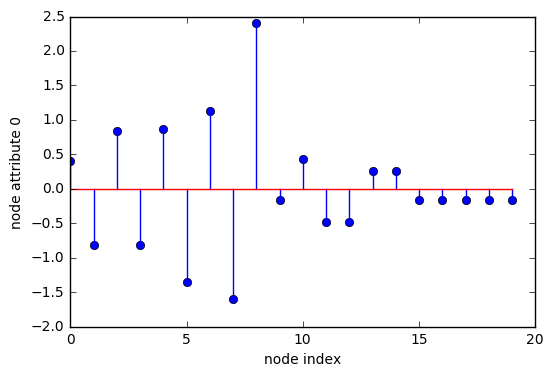

In [5]:
Tmax = 5
G0_node, X0, hist_tv = LSN.smooth_gsignal_generate(G0, T=Tmax, sigma=5, alpha=0, overwrite=True)
fig1 = plt.figure(1)
plt.stem(np.arange(X0.shape[0]),X0[:,0])
plt.xlabel('node index')
plt.ylabel('node attribute 0')
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_node_fea0.eps"
if savefigure : fig1.savefig(filename)

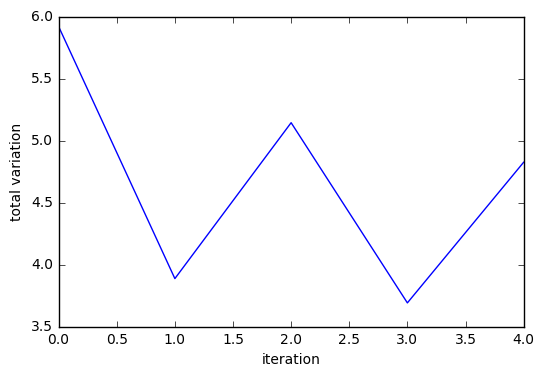

In [6]:
fig2 = plt.figure(2)
plt.plot(np.arange(Tmax), hist_tv, 'b')
plt.xlabel('iteration')
plt.ylabel('total variation')
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_tv.eps"
if savefigure : fig2.savefig(filename)

In [7]:
if choice == 'newman' or choice == 'tree':
    pos=nx.circular_layout(G0, dim=2, scale=1.0, center=None)
elif choice != 'newman':
    pos=nx.nx_pydot.graphviz_layout(G0)
    
pos_coordinate = np.array([[pos[key][0], pos[key][1]] for key in pos])
X0, nodeIdx = LSN.get_node_attributes(G0)
edge_list = LSN.get_edgelist(G0)

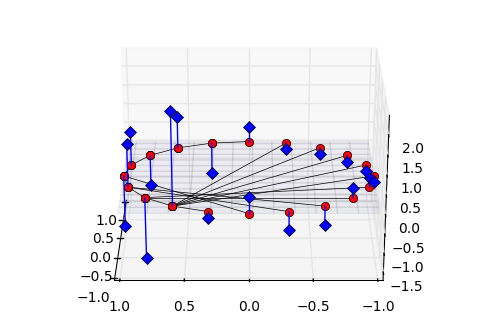

In [8]:
view_angle = [25, 180] #[25, 25]
LSN.plot_node_3d(pos_coordinate, edge_list, X0, view_angle=view_angle, nodeIdx=nodeIdx, save_fig=savefigure)

In [9]:
tv = LSN.compute_total_variation(G0)
tv

4.8244643059380881

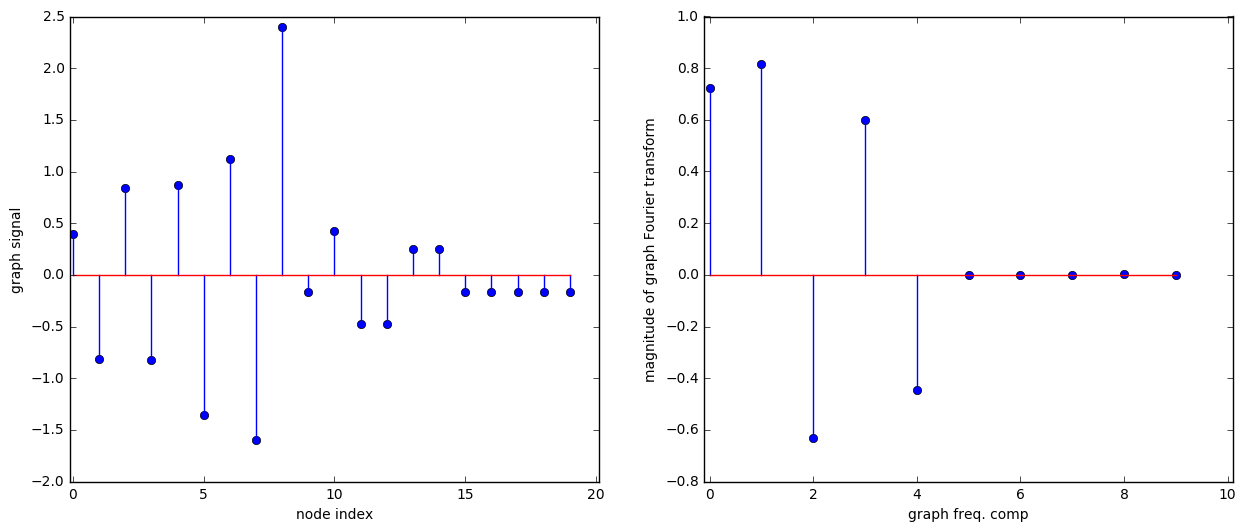

In [10]:
GFx0 = LSN.graph_fourier_transform(X0, show_fig=True, save_fig = savefigure)

##  Smooth network data $\mathbf{X}$ on graph are not full rank 

In [11]:
X0_c = X0 - np.mean(X0, axis=0)
# find the sample covariance matrix 
S0 = np.dot(X0_c, X0_c.T)/X0_c.shape[1]
Lambda0, Us0 = np.linalg.eigh(S0)
idx = Lambda0.argsort()[::-1]   
Lambda0 = Lambda0[idx]
Us0 = Us0[:,idx]
r = np.linalg.matrix_rank(S0)
print("rank of covariance matrix " + str(r) + " / " + str(X0.shape[0]) )

rank of covariance matrix 10 / 20


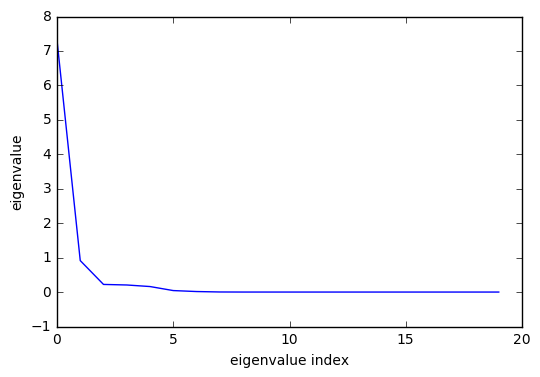

In [12]:
plt.plot(np.arange(len(Lambda0)), Lambda0)
plt.xlabel("eigenvalue index")
plt.ylabel("eigenvalue")
plt.show()

##  Independent Component Analysis

\begin{align}
\mathbf{X} &= \mathbf{S}\mathbf{H}
\end{align} 

where $\mathbf{S}\in \mathbb{R}^{N\times k}$ is the _unknown mixing_ matrix with orthogonality constraint $\mathbf{S}^{T}\mathbf{S} = \mathbf{I}$ and $\mathbf{H} \in \mathbb{R}^{k\times p}$ is the unknown independent sources.  

Note that $\mathbf{X}$ is _centered_ and _whitened_ data.  The ICA finds $\mathbf{S}$ such that a _non-quadratic nonlinear_ function $f(\mathbf{S}^{T}\mathbf{X})$ that measures the __non-gaussianity__ is _maximized_. This is due to the fact from the Central Limit Theorem that the sum of non-Gaussian independent variables are more gaussian if both weights are non-zero. In other word, to maximize the non-gaussianity, one of the weight in $\mathbf{s}_{i}$ must be zero. This lead to sparse activation of $\mathbf{S}$ as a result. 

In [13]:
from sklearn.decomposition import PCA, FastICA

In [14]:
seed = 1000
ica_model = FastICA(n_components=4, random_state=seed, max_iter = 1000)

In [15]:
X0.shape

(20, 10)

In [16]:
H = ica_model.fit(X0.T).transform(X0.T)
S = ica_model.mixing_ 
H /= H.std(axis=0)
H = H.T

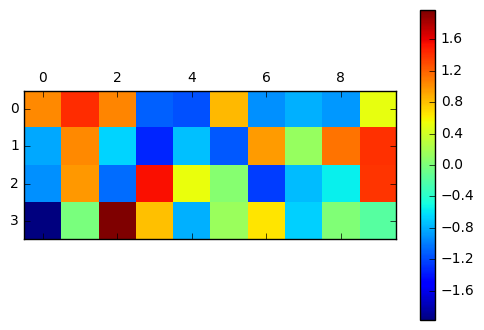

In [17]:
#savefigure = True
fig4 = plt.figure(4)
ax = fig4.add_subplot(111)
cax = ax.matshow(H)
fig4.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_ICA_h.eps"
if savefigure : fig4.savefig(filename)

In [18]:
S.shape

(20, 4)

In [19]:
from sklearn import preprocessing
X0_scaled = preprocessing.scale(X0)

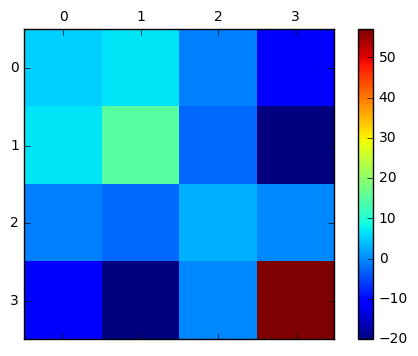

In [20]:
fig4 = plt.figure(4)
ax = fig4.add_subplot(111)
cax = ax.matshow(np.dot(S.T, S))
fig4.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_ICA_s2.eps"
if savefigure : fig4.savefig(filename)

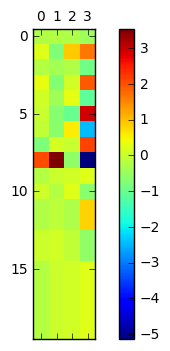

In [21]:
#savefigure = True
fig4 = plt.figure(4)
ax = fig4.add_subplot(111)
cax = ax.matshow(S)
fig4.colorbar(cax)
#cbar.ax.set_yticklabels(['< -1', '0', '> 1'])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_ICA_w.eps"
if savefigure : fig4.savefig(filename)

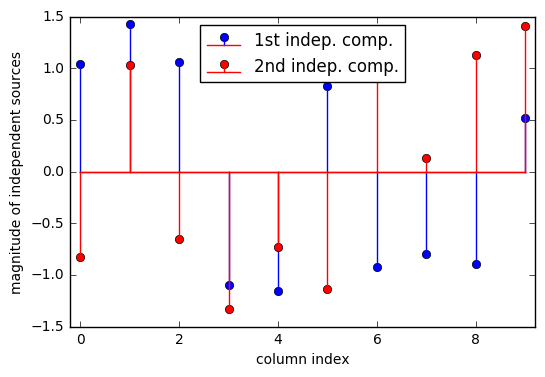

In [22]:
h4= plt.figure(1)
ax = plt.gcf()
markerline, stemlines, baseline = plt.stem(np.arange(H.shape[1]),H[0,:],'b')
markerline2, stemlines2, baseline2 = plt.stem(np.arange(H.shape[1]),H[1,:],'r')
plt.setp(markerline2, 'markerfacecolor', 'r')    # make points blue 
plt.xlabel('column index')
plt.ylabel('magnitude of independent sources')
plt.legend(['1st indep. comp.', '2nd indep. comp.'], loc='best', numpoints=1)
plt.xlim([min(np.arange(H.shape[1]))-0.2, max(np.arange(H.shape[1]))+0.2])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_ICA_h.eps"
if savefigure : h4.savefig(filename)

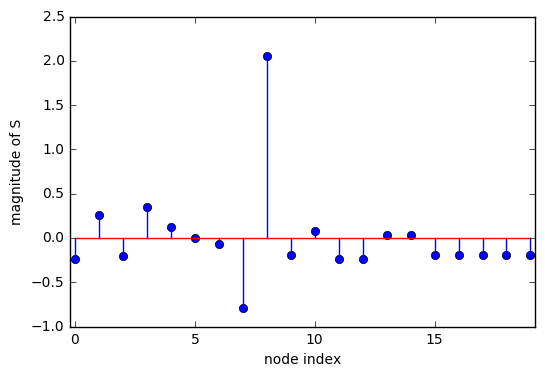

In [23]:
h4= plt.figure(1)
ax = plt.gcf()
markerline, stemlines, baseline = plt.stem(np.arange(S.shape[0]),S[:,0],'b')
#markerline2, stemlines2, baseline2 = plt.stem(np.arange(H.shape[1]),W[:,],'r')
#plt.setp(markerline2, 'markerfacecolor', 'r')    # make points blue 
plt.xlabel('node index')
plt.ylabel('magnitude of S')
#plt.legend(['1st indep. comp.', '2nd indep. comp.'], loc='best', numpoints=1)
plt.xlim([min(np.arange(S.shape[0]))-0.2, max(np.arange(S.shape[0]))+0.2])
plt.show()
filename = "../figures/"+strftime("%d%m%Y_%H%M%S", gmtime()) + "_ICA_w_plot.eps"
if savefigure : h4.savefig(filename)

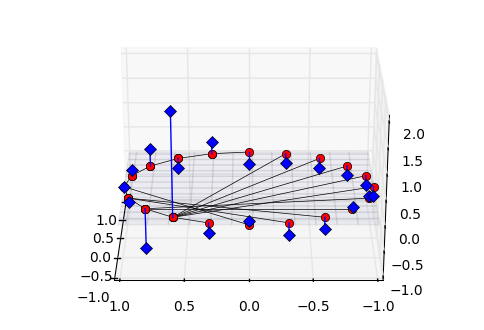

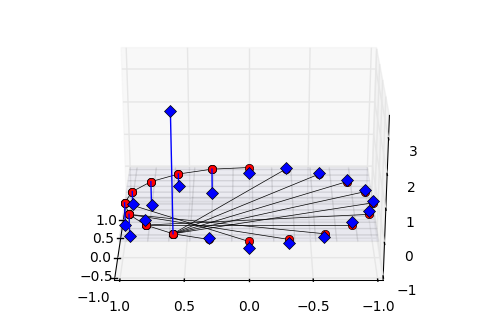

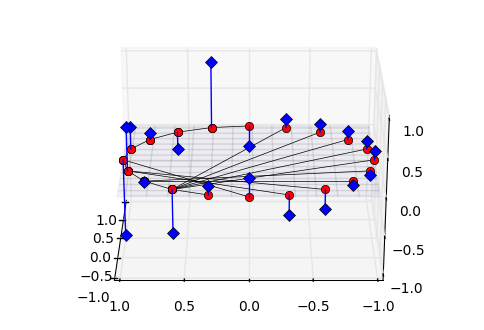

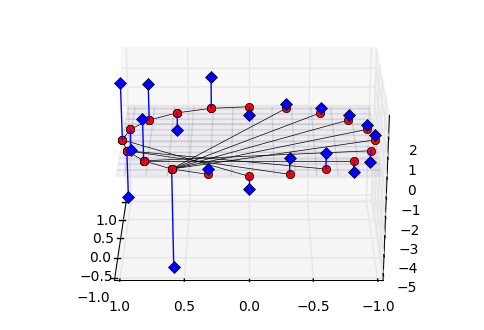

In [24]:
for i in range(S.shape[1]):
    #val = S[:,i]
    LSN.plot_node_3d(pos_coordinate, edge_list, S, view_angle=view_angle, columnIdx=i, figIdx=i+5, nodeIdx=nodeIdx, save_fig=savefigure)
    

##  Learning hidden variables from factor analysis

\begin{align}
\mathbf{X} &= \mathbf{U}\mathbf{H} + \mathbf{N}
\end{align}

Learning the hidden variables $\mathbf{h}$ from given data $\mathbf{X}$ that satisfies 

\begin{align}
\min_{\mathbf{H} \in \mathbb{R}^{k\times p}}\,&\phantom{=} \frac{1}{2}\|\mathbf{X} - \mathbf{U}\mathbf{H}\|_{F}^{2} + \frac{1}{2\sigma^2}\mathbf{H}^{T}\mathbf{\Lambda}\mathbf{H}\\
&= \frac{1}{2}\mathbf{X}^{T}\mathbf{X} -\frac{1}{2}\mathbf{H}^{T}\mathbf{U}^{T}\mathbf{X} - \frac{1}{2}\mathbf{X}^{T}\mathbf{U}\mathbf{H} +\frac{1}{2}\mathbf{H}^{T}\left(\frac{1}{\sigma^2}\mathbf{\Lambda} + \mathbf{I}\right)\mathbf{H},
\end{align}

And the result is 
$$ \mathbf{H} = \left(\frac{1}{\sigma^2}\mathbf{\Lambda} + \mathbf{I}\right)^{-1}\mathbf{U}^{T}\mathbf{X}$$

where $\mathbf{L} = \mathbf{U}\mathbf{\Lambda}\mathbf{U}^{T}$ is the eigen-decomposition 

The reconstructed signal is $$ \mathbf{Y} = \mathbf{U}\mathbf{H} $$


In [25]:
sigma2 = 0.1
# Find the hidden variable via linear regression 
H=LSN.inference_hidden_graph_regul(sigma=np.sqrt(sigma2))
Y= np.dot(LSN.U,H)/sigma2
#h5 = plt.figure(5)
#plt.subplot(1,2,1)

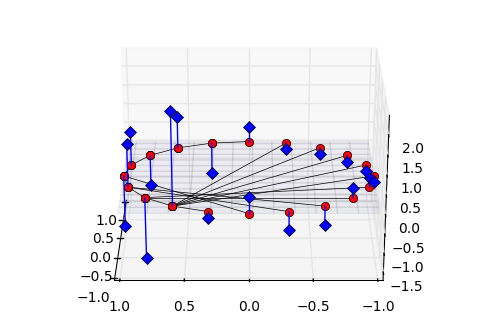

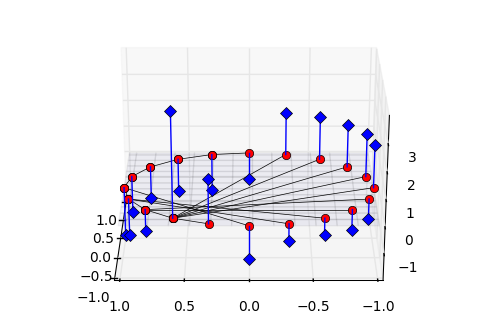

In [26]:
LSN.plot_node_3d(pos_coordinate, edge_list, X0, view_angle=view_angle, figIdx=1, nodeIdx=nodeIdx, save_fig=savefigure)
LSN.plot_node_3d(pos_coordinate, edge_list, Y, view_angle=view_angle, figIdx=2, nodeIdx=nodeIdx,save_fig=savefigure)

In [27]:
# Find the hidden variable via linear regression 
np.random.seed(2000)
Xint = 3*np.random.randn(np.sum(size), d)
H=LSN.inference_hidden_graph_regul(sigma=np.sqrt(sigma2), init_X = Xint )
Y= np.dot(LSN.U,H)/sigma2

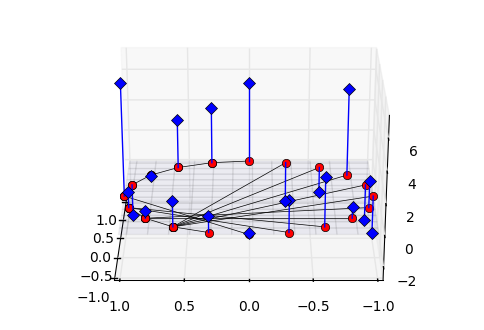

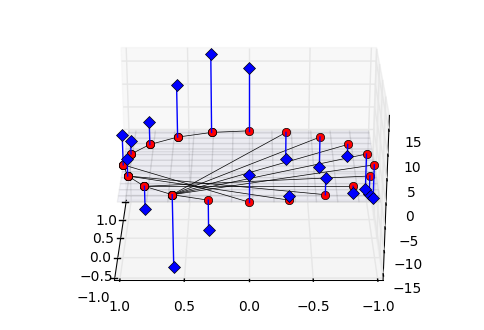

In [28]:
LSN.plot_node_3d(pos_coordinate, edge_list, Xint, view_angle=view_angle, nodeIdx=nodeIdx, figIdx=3, save_fig=savefigure)
LSN.plot_node_3d(pos_coordinate, edge_list, Y, view_angle=view_angle, nodeIdx=nodeIdx, figIdx=4, save_fig=savefigure)

In [29]:
LSN.L_eig/sigma2 + np.ones(LSN.L_eig.shape)

array([  1.33385199,   2.14627482,   3.75948063,   5.14696454,
         6.48745794,  11.        ,  11.        ,  11.        ,
        11.        ,  11.        ])